# Figure. Functional Annotation and Fine Mapping

In [1]:
import cPickle
import glob
import os
import random
import subprocess

import cdpybio as cpb
from ipyparallel import Client
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pybedtools as pbt
from scipy.stats import fisher_exact
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels as sms
import tabix
import vcf as pyvcf
import weblogolib as logo

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'figure_functional_annotation_and_fine_mapping'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

Each figure should be able to fit on a single 8.5 x 11 inch page. Please do not send figure panels as individual files. We use three standard widths for figures: 1 column, 85 mm; 1.5 column, 114 mm; and 2 column, 174 mm (the full width of the page). Although your figure size may be reduced in the print journal, please keep these widths in mind. For Previews and other three-column formats, these widths are also applicable, though the width of a single column will be 55 mm.

In [2]:
sns.set_style('whitegrid')

In [3]:
fn = os.path.join(ciepy.root, 'output', 'functional_annotation_analysis', 'encode_dnase_res.tsv')
dnase_res = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'functional_annotation_analysis', 'encode_stem_cell_chip_seq_res.tsv')
tf_res = pd.read_table(fn, index_col=0)
tf_res = tf_res.drop_duplicates(subset=['target'])

fn = os.path.join(ciepy.root, 'output', 'fine_mapping', 'tf_disruption.tsv')
tf_disrupt = pd.read_table(fn, index_col=0)

## Paper

In [5]:
tdf = dnase_res[dnase_res.biosample_type != 'immortalized cell line'].copy(deep=True)
a = tdf.shape[0]
b = tdf.cell_type.value_counts().shape[0]
print('{} samples from {} cell types.'.format(a, b))
print('{} skin fibroblasts.'.format(sum(tdf.cell_type == 'skin fibroblast')))

123 samples from 78 cell types.
9 skin fibroblasts.


In [7]:
tdf.sort_values(by='pvalue', inplace=True)
np.where(tdf.cell_type == 'skin fibroblast')

(array([16, 27, 39, 61, 62, 64, 72, 90, 94]),)

In [8]:
tf_res.target_type.value_counts()

transcription factor                                                                                39
chromatin remodeller, transcription factor                                                           8
RNA binding protein, transcription factor                                                            3
broad histone mark, histone, histone modification                                                    2
chromatin remodeller, other context, other post-translational modification, transcription factor     1
histone, histone modification, narrow histone mark                                                   1
Name: target_type, dtype: int64

In [9]:
tf_res = tf_res[tf_res.target_type != 'histone, histone modification']

In [10]:
tf_res.sort_values(by='pvalue', inplace=True)

In [11]:
tf_res.shape

(54, 8)

In [12]:
np.where(tf_res.target == 'POU5F1')

(array([17]),)

In [13]:
t = dnase_res[dnase_res.biosample_type != 'immortalized cell line']
t = dnase_res.ix[t.index].sort_values(by='pvalue', ascending=False).tail(10)

In [14]:
t = dnase_res[dnase_res.biosample_type != 'immortalized cell line']
t = dnase_res.ix[t.index].sort_values(by='pvalue', ascending=False).tail(10)
t.cell_type = t.cell_type.apply(lambda x: x.replace('induced pluripotent stem cell', 'iPSC'))
t.cell_type = t.cell_type.apply(lambda x: x.replace('fibroblast of ', ''))

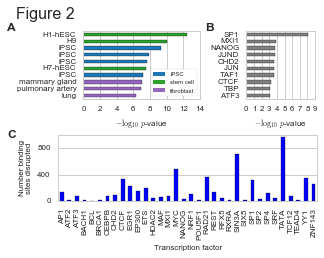

In [17]:
fig = plt.figure(figsize=(4.48, 3.7), dpi=300)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.text(0, 1, 'Figure 2',
        size=16, va='top')
ciepy.clean_axis(ax)
ax.set_xticks([])
ax.set_yticks([])
gs.tight_layout(fig, rect=[0, 0.90, 0.5, 1])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
t = dnase_res[dnase_res.biosample_type != 'immortalized cell line']
t = dnase_res.ix[t.index].sort_values(by='pvalue', ascending=False).tail(10)
t.cell_type = t.cell_type.apply(lambda x: x.replace('induced pluripotent stem cell', 'iPSC'))
t.cell_type = t.cell_type.apply(lambda x: x.replace('fibroblast of ', ''))
# cdict = dict(zip(set(dnase_res.ix[t.index, 'biosample_type']), sns.color_palette('Set2')))
cdict = dict([['induced pluripotent stem cell line', cpb.analysis.tableau20[0]],
              ['stem cell', cpb.analysis.tableau20[4]],
              ['primary cell', cpb.analysis.tableau20[8]]])
#fig, ax = plt.subplots(1, 1, figsize=(5, 10))
c = [cdict[x] for x in dnase_res.ix[t.index, 'biosample_type']]
ax = (-np.log10(t.pvalue)).plot(kind='barh', ax=ax, color=c, label=None)
ax.set_ylabel('')
ax.set_xlabel('$-\log_{10}$ $p$-value', fontsize=8)
#ax.set_title('ENCODE DNase enrichments')
ya, yb = ax.get_ylim()
ax.set_yticklabels(t.ix[t.index, 'cell_type'], fontsize=8)
rects = []
labels = []
for k in ['induced pluripotent stem cell line', 'stem cell',
          'primary cell',]:
    if k == 'induced pluripotent stem cell line':
        labels.append('iPSC')
    elif k == 'in vitro differentiated cells':
        labels.append('in vitro\ndifferentiated\ncell')
    elif k == 'primary cell':
        labels.append('fibroblast')
    else:
        labels.append(k)
    r = plt.Rectangle((0, 0), 0, 0, fc=cdict[k])
    rects.append(r)
lgd = ax.legend(rects, labels, loc='lower right', frameon=True, fontsize=6)
#bbox_to_anchor=[0.5, -0.05])#, prop={'size':8}), loc='upper center',
for p in lgd.get_patches():
    p.set_linewidth(0)
ax.grid(axis='y')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
gs.tight_layout(fig, rect=[0, 0.47, 0.65, 0.91])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
t = tf_res.sort_values(by='pvalue', ascending=False).tail(10)
ax = (-np.log10(t.pvalue)).plot(kind='barh', ax=ax, color='grey', zorder=2)
ax.set_ylabel('')
ax.set_xlabel('$-\log_{10}$ $p$-value', fontsize=8)
ya, yb = ax.get_ylim()
t = ax.set_yticklabels(t.target, fontsize=8)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.grid(axis='y')
gs.tight_layout(fig, rect=[0.6, 0.47, 1, 0.91])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
tf_disrupt.sum().plot(kind='bar')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.grid(axis='x')
ax.set_yticks(ax.get_yticks()[0::2])
ax.yaxis.set_major_formatter(ciepy.comma_format)
ax.set_xlabel('Transcription factor', fontsize=8)
ax.set_ylabel('Number binding\nsites disrupted', fontsize=8)
gs.tight_layout(fig, rect=[0, 0, 1, 0.52])

t = fig.text(0.005, 0.87, 'A', weight='bold', 
             size=12)
t = fig.text(0.62, 0.87, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.47, 'C', weight='bold', 
             size=12)
# t = fig.text(0.7, 0.56, 'D', weight='bold', 
#              size=12)
# t = fig.text(0.005, 0.25, 'E', weight='bold', 
#              size=12)

fig.savefig(os.path.join(outdir, 'functional_annotation_tf_disruption.pdf'))
fig.savefig(os.path.join(outdir, 'functional_annotation_tf_disruption.png'), dpi=300)

## Presentation

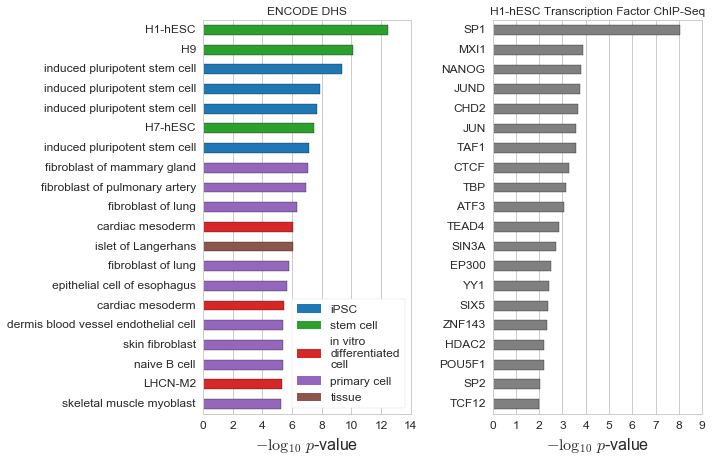

In [16]:
fig = plt.figure(figsize=(10, 6.5), dpi=300)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
t = dnase_res[dnase_res.biosample_type != 'immortalized cell line']
t = dnase_res.ix[t.index].sort_values(by='pvalue', ascending=False).tail(20)
# cdict = dict(zip(set(dnase_res.ix[t.index, 'biosample_type']), sns.color_palette('Set2')))
cdict = dict([['induced pluripotent stem cell line', cpb.analysis.tableau20[0]],
              ['stem cell', cpb.analysis.tableau20[4]],
              ['in vitro differentiated cells', cpb.analysis.tableau20[6]],
              ['primary cell', cpb.analysis.tableau20[8]], 
              ['tissue', cpb.analysis.tableau20[10]]])
#fig, ax = plt.subplots(1, 1, figsize=(5, 10))
c = [cdict[x] for x in dnase_res.ix[t.index, 'biosample_type']]
ax = (-np.log10(t.pvalue)).plot(kind='barh', ax=ax, color=c, label=None)
ax.set_ylabel('')
ax.set_xlabel('$-\log_{10}$ $p$-value', fontsize=16)
#ax.set_title('ENCODE DNase enrichments')
ya, yb = ax.get_ylim()
ax.set_yticklabels(dnase_res.ix[t.index, 'cell_type'], fontsize=8)
rects = []
labels = []
for k in ['induced pluripotent stem cell line', 'stem cell',
          'in vitro differentiated cells', 'primary cell', 'tissue']:
    if k == 'induced pluripotent stem cell line':
        labels.append('iPSC')
    elif k == 'in vitro differentiated cells':
        labels.append('in vitro\ndifferentiated\ncell')
    else:
        labels.append(k)
    r = plt.Rectangle((0, 0), 0, 0, fc=cdict[k])
    rects.append(r)
lgd = ax.legend(rects, labels, loc='lower right', frameon=True, fontsize=12)
#bbox_to_anchor=[0.5, -0.05])#, prop={'size':8}), loc='upper center',
for p in lgd.get_patches():
    p.set_linewidth(0)
ax.grid(axis='y')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(12)
ax.set_title('ENCODE DHS')
gs.tight_layout(fig, rect=[0, 0, 0.6, 1])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
t = tf_res.sort_values(by='pvalue', ascending=False).tail(20)
ax = (-np.log10(t.pvalue)).plot(kind='barh', ax=ax, color='grey')
ax.set_ylabel('')
ax.set_xlabel('$-\log_{10}$ $p$-value', fontsize=16)
ya, yb = ax.get_ylim()
t = ax.set_yticklabels(t.target, fontsize=8)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(12)
ax.grid(axis='y')
ax.set_title('H1-hESC Transcription Factor ChIP-Seq')
gs.tight_layout(fig, rect=[0.6, 0, 1, 1])

fig.savefig(os.path.join(outdir, 'dnase_tf_presentation.pdf'))